In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
incidents_data = pd.read_csv('incidents.csv')
incidents_data.head()

,Incident_ID,Customer_ID,Age,Gender,Season,Weather,Activity,Slope_Name,Slope_Difficulty,Skill_Level,Protective_Gear,Injuries,Injury_Severity,Response_Time,Hospital_Transport,Hospital_Stay_Length
0,0,2679,33,Male,Winter,Foggy,Skiing,Bunny Hill,Easy,Beginner,Helmet,Sprain,6,15,No,0
1,1,4257,36,Female,Summer,Sunny,Hiking,Devil’s Drop,Expert,Beginner,Helmet,Fracture,6,23,No,0
2,2,7924,47,Female,Winter,Foggy,Snowboarding,Thunder Run,Advanced,Beginner,Helmet,Sprain,8,13,Yes,1
3,3,7224,56,Male,Summer,Sunny,Hiking,Thunder Run,Advanced,Intermediate,Helmet,Fracture,5,9,No,0
4,4,9785,17,Male,Summer,Windy,Climbing,Blue Ridge,Intermediate,Beginner,NaN,Head Injury,8,10,Yes,4


In [3]:
activity_number = (
    incidents_data
    .groupby("Activity")
    .agg(count=("Activity", "size"))
    .reset_index()
)
activity_number

,Activity,count
0,Climbing,158
1,Hiking,153
2,Mountain Biking,177
3,Skiing,247
4,Snowboarding,265


In [4]:
slope_risk_intensity = incidents_data.groupby("Slope_Name")["Injury_Severity"].median().reset_index(name='median_injury_severity')
slope_risk_intensity

,Slope_Name,median_injury_severity
0,Blue Ridge,5.0
1,Bunny Hill,5.0
2,Devil’s Drop,7.0
3,Rocky Pass,5.0
4,Shadow Valley,6.0
5,Summit Peak,5.0
6,Thunder Run,5.0


In [5]:
slope_risk_likelihood = (
    incidents_data
    .groupby("Slope_Name")
    .size()
    .reset_index(name="count")
)
slope_risk_likelihood

,Slope_Name,count
0,Blue Ridge,143
1,Bunny Hill,122
2,Devil’s Drop,141
3,Rocky Pass,138
4,Shadow Valley,132
5,Summit Peak,174
6,Thunder Run,150


In [6]:
mean_response_time_by_slope = incidents_data.groupby('Slope_Name')['Response_Time'].median().reset_index(name='Response_Time')
mean_response_time_by_slope

,Slope_Name,Response_Time
0,Blue Ridge,13.0
1,Bunny Hill,13.0
2,Devil’s Drop,19.0
3,Rocky Pass,13.0
4,Shadow Valley,12.0
5,Summit Peak,13.0
6,Thunder Run,13.0


In [7]:
# Merge the first two DataFrames
data_by_slope = pd.merge(slope_risk_likelihood, mean_response_time_by_slope, on="Slope_Name", how="outer")

# Merge the result with the third DataFrame
data_by_slope = pd.merge(data_by_slope, slope_risk_intensity, on="Slope_Name", how="outer")

data_by_slope

,Slope_Name,count,Response_Time,median_injury_severity
0,Blue Ridge,143,13.0,5.0
1,Bunny Hill,122,13.0,5.0
2,Devil’s Drop,141,19.0,7.0
3,Rocky Pass,138,13.0,5.0
4,Shadow Valley,132,12.0,6.0
5,Summit Peak,174,13.0,5.0
6,Thunder Run,150,13.0,5.0


In [8]:
incidents_data["Protective_Gear"] = incidents_data["Protective_Gear"].fillna("None")
protection_injury_dist = incidents_data.groupby(['Injuries']).size().reset_index()
protection_injury_dist

,Injuries,0
0,Concussion,167
1,Fracture,420
2,Head Injury,70
3,Sprain,343


In [9]:
def categorize_severity(severity):
    if severity < 4:
        return "Light"
    elif severity < 7:
        return "Moderate"
    else:
        return "Critical"

# Apply the function to create a new column
incidents_data["Severity_Category"] = incidents_data["Injury_Severity"].apply(categorize_severity)

In [10]:
severity_level_dist = incidents_data.groupby(['Slope_Name', 'Severity_Category']).size().reset_index()
severity_level_dist

,Slope_Name,Severity_Category,0
0,Blue Ridge,Critical,38
1,Blue Ridge,Light,22
2,Blue Ridge,Moderate,83
3,Bunny Hill,Critical,33
4,Bunny Hill,Light,14
5,Bunny Hill,Moderate,75
6,Devil’s Drop,Critical,108
7,Devil’s Drop,Moderate,33
8,Rocky Pass,Critical,34
9,Rocky Pass,Light,23


In [64]:
# Multi-level groupby: slope, season, weather, severity
multi_factors = (
    incidents_data
    .groupby(["Slope_Name", "Injury_Severity"])
    .size()  # Count occurrences
    .reset_index(name="Incident_Count")  # Rename count column
)

print("=== Hospital Transport: Response Time by Slope, Season, Weather, Severity ===")
print(multi_factors)

=== Hospital Transport: Response Time by Slope, Season, Weather, Severity ===
       Slope_Name  Injury_Severity  Incident_Count
0      Blue Ridge                2              10
1      Blue Ridge                3              12
2      Blue Ridge                4              25
3      Blue Ridge                5              37
4      Blue Ridge                6              21
5      Blue Ridge                7              20
6      Blue Ridge                8              14
7      Blue Ridge                9               4
8      Bunny Hill                2               3
9      Bunny Hill                3              11
10     Bunny Hill                4              26
11     Bunny Hill                5              25
12     Bunny Hill                6              24
13     Bunny Hill                7              19
14     Bunny Hill                8              11
15     Bunny Hill                9               3
16   Devil’s Drop                4               6
17  

In [68]:
# Calculate weighted sum of Injury_Severity for each Slope_Name
weighted_severity = (
    multi_factors.assign(Severity_Score=multi_factors["Injury_Severity"] * multi_factors["Incident_Count"])
    .groupby("Slope_Name")["Severity_Score"].sum()
    .reset_index()
)

# Display the resulting table
weighted_severity

,Slope_Name,Severity_Score
0,Blue Ridge,755
1,Bunny Hill,660
2,Devil’s Drop,1091
3,Rocky Pass,724
4,Shadow Valley,713
5,Summit Peak,941
6,Thunder Run,747


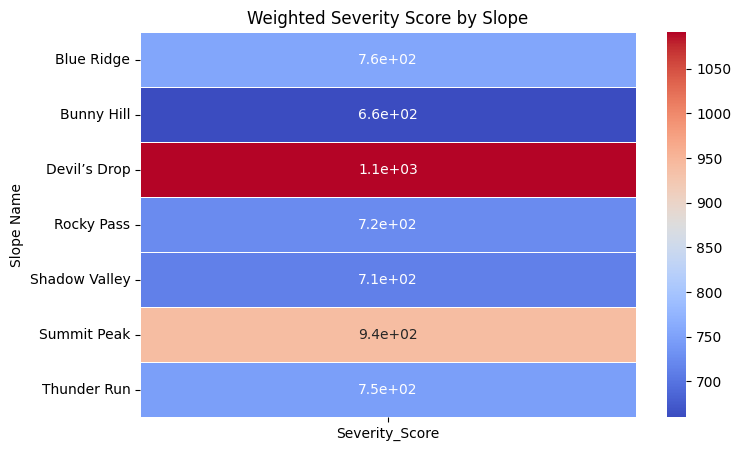

In [71]:
# Plot a heatmap
plt.figure(figsize=(8, 5))
sns.heatmap(weighted_severity.set_index("Slope_Name"), annot=True, cmap="coolwarm", linewidths=0.5)
plt.title("Weighted Severity Score by Slope")
plt.xlabel("")
plt.ylabel("Slope Name")
plt.xticks(rotation=0)

# Show the heatmap
plt.show()

In [77]:
# Filter the dataset for Winter and Summer separately
winter_data = incidents_data[incidents_data["Season"] == "Winter"]
summer_data = incidents_data[incidents_data["Season"] == "Summer"]

In [85]:
multi_factors_activity = (
    incidents_data
    .groupby(["Activity", "Injury_Severity"])
    .size()  # Count occurrences
    .reset_index(name="Incident_Count")  # Rename count column
)

# Calculate weighted sum of Injury_Severity for each Slope_Name
weighted_severity_activity = (
    multi_factors_activity.assign(Severity_Score=multi_factors_activity["Injury_Severity"] * multi_factors_activity["Incident_Count"])
    .groupby("Activity")["Severity_Score"].sum()
    .reset_index()
)

# Display the resulting table
weighted_severity_activity

,Activity,Severity_Score
0,Climbing,1129
1,Hiking,572
2,Mountain Biking,832
3,Skiing,1434
4,Snowboarding,1664


In [88]:
multi_factors_slope = (
    summer_data
    .groupby(["Slope_Name", "Injury_Severity"])
    .size()  # Count occurrences
    .reset_index(name="Incident_Count")  # Rename count column
)

# Calculate weighted sum of Injury_Severity for each Slope_Name
weighted_severity_activity = (
    multi_factors_slope.assign(Severity_Score=multi_factors_slope["Injury_Severity"] * multi_factors_slope["Incident_Count"])
    .groupby("Slope_Name")["Severity_Score"].sum()
    .reset_index()
)

# Display the resulting table
weighted_severity_activity

,Slope_Name,Severity_Score
0,Blue Ridge,342
1,Bunny Hill,272
2,Devil’s Drop,464
3,Rocky Pass,346
4,Shadow Valley,308
5,Summit Peak,429
6,Thunder Run,372


In [92]:
multi_factors_slope = (
    winter_data
    .groupby(["Protective_Gear", "Injury_Severity"])
    .size()  # Count occurrences
    .reset_index(name="Incident_Count")  # Rename count column
)

# Calculate weighted sum of Injury_Severity for each Slope_Name
weighted_severity_activity = (
    multi_factors_slope.assign(Severity_Score=multi_factors_slope["Injury_Severity"] * multi_factors_slope["Incident_Count"])
    .groupby("Protective_Gear")["Severity_Score"].sum()
    .reset_index()
)

# Display the resulting table
weighted_severity_activity

,Protective_Gear,Severity_Score
0,Helmet,1071
1,None,1055
2,Pads,972


In [75]:
multi_factors_activity = (
    incidents_data
    .groupby(["Activity", "Injury_Severity"])
    .size()  # Count occurrences
    .reset_index(name="Incident_Count")  # Rename count column
)

multi_factors_activity

,Activity,Injury_Severity,Incident_Count
0,Climbing,5,29
1,Climbing,6,31
2,Climbing,7,35
3,Climbing,8,24
4,Climbing,9,29
5,Climbing,10,10
6,Hiking,2,40
7,Hiking,3,25
8,Hiking,4,41
9,Hiking,5,35


In [76]:
# Calculate weighted sum of Injury_Severity for each Slope_Name
weighted_severity_activity = (
    multi_factors_activity.assign(Severity_Score=multi_factors_activity["Injury_Severity"] * multi_factors_activity["Incident_Count"])
    .groupby("Activity")["Severity_Score"].sum()
    .reset_index()
)

# Display the resulting table
weighted_severity_activity

,Activity,Severity_Score
0,Climbing,1129
1,Hiking,572
2,Mountain Biking,832
3,Skiing,1434
4,Snowboarding,1664


In [12]:
incidents_data.groupby('Season').size().reset_index(name='count')

,Season,count
0,Summer,488
1,Winter,512


In [13]:
devil_drop_data = incidents_data[incidents_data['Slope_Name']=="Devil’s Drop"]
devil_drop_data

,Incident_ID,Customer_ID,Age,Gender,Season,Weather,Activity,Slope_Name,Slope_Difficulty,Skill_Level,Protective_Gear,Injuries,Injury_Severity,Response_Time,Hospital_Transport,Hospital_Stay_Length,Severity_Category
1,1,4257,36,Female,Summer,Sunny,Hiking,Devil’s Drop,Expert,Beginner,Helmet,Fracture,6,23,No,0,Moderate
6,6,5554,16,Female,Winter,Foggy,Skiing,Devil’s Drop,Expert,Beginner,Helmet,Concussion,7,18,No,0,Critical
12,12,3621,37,Female,Winter,Windy,Skiing,Devil’s Drop,Expert,Beginner,Helmet,Fracture,10,19,Yes,2,Critical
14,14,8433,40,Male,Summer,Rainy,Mountain Biking,Devil’s Drop,Expert,Intermediate,Pads,Sprain,5,18,No,0,Moderate
21,21,1964,17,Male,Winter,Snowy,Skiing,Devil’s Drop,Expert,Beginner,None,Sprain,6,18,No,0,Moderate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
959,959,4519,22,Female,Summer,Sunny,Hiking,Devil’s Drop,Expert,Intermediate,Helmet,Sprain,7,16,No,0,Critical
964,964,7086,52,Female,Winter,Foggy,Snowboarding,Devil’s Drop,Expert,Advanced,Helmet,Fracture,8,19,No,0,Critical
977,977,7388,50,Male,Winter,Snowy,Snowboarding,Devil’s Drop,Expert,Advanced,Helmet,Concussion,9,16,No,0,Critical
983,983,5739,19,Male,Winter,Windy,Snowboarding,Devil’s Drop,Expert,Beginner,Pads,Sprain,9,19,No,0,Critical


<BarContainer object of 5 artists>

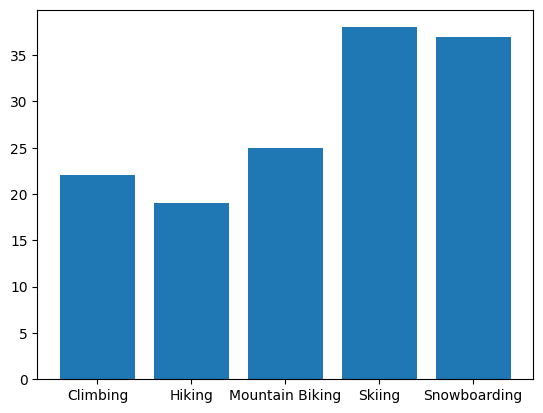

In [14]:
activity_dist = devil_drop_data.groupby('Activity').size().reset_index(name='count')
plt.bar(activity_dist['Activity'], activity_dist['count'])

In [15]:
devil_drop_data.groupby('Weather').size().reset_index(name='count')

,Weather,count
0,Foggy,25
1,Rainy,25
2,Snowy,22
3,Sunny,29
4,Windy,40


In [16]:
incidents_data.groupby('Weather').size().reset_index(name='count')

,Weather,count
0,Foggy,146
1,Rainy,154
2,Snowy,130
3,Sunny,257
4,Windy,313


In [17]:
incidents_data.groupby('Slope_Difficulty').size().reset_index(name='count')

,Slope_Difficulty,count
0,Advanced,324
1,Easy,122
2,Expert,273
3,Intermediate,281


In [18]:
slope_skills_matching = (
    incidents_data
    .groupby(["Skill_Level", "Slope_Difficulty"])
    .size()
    .reset_index(name="count")
)

experience_vs_slope_pivot = slope_skills_matching.pivot(index="Skill_Level", columns="Slope_Difficulty", values="count").fillna(0)
experience_vs_slope_pivot

Slope_Difficulty,Advanced,Easy,Expert,Intermediate
Skill_Level,,,,
Advanced,96,47,97,104
Beginner,107,40,95,87
Intermediate,121,35,81,90


In [19]:
# Calculate total number of Beginners
total_beginners = experience_vs_slope_pivot.loc["Beginner"].sum()

# Get the number of Beginners choosing Advanced slopes
beginners_on_advanced = experience_vs_slope_pivot.loc["Beginner", "Advanced"]
beginners_on_expert = experience_vs_slope_pivot.loc["Beginner", "Expert"]
beginners_on_intermediate = experience_vs_slope_pivot.loc["Beginner", "Intermediate"]

# Calculate percentage
percentage_beginners_diffskills = ((beginners_on_advanced + beginners_on_expert + beginners_on_intermediate) / total_beginners) * 100

percentage_beginners_diffskills

87.84194528875379

In [20]:
# Calculate total number of Beginners
total_beginners = experience_vs_slope_pivot.loc["Beginner"].sum()

# Get the number of Beginners choosing Advanced slopes
beginners_on_advanced = experience_vs_slope_pivot.loc["Beginner", "Advanced"]
beginners_on_expert = experience_vs_slope_pivot.loc["Beginner", "Expert"]
beginners_on_intermediate = experience_vs_slope_pivot.loc["Beginner", "Intermediate"]

# Calculate percentage
percentage_beginners_highskills = ((beginners_on_advanced + beginners_on_expert) / total_beginners) * 100

percentage_beginners_highskills

61.39817629179332

In [21]:
total_intermediate = experience_vs_slope_pivot.loc["Intermediate"].sum()

intermediate_on_advanced = experience_vs_slope_pivot.loc["Intermediate", "Advanced"]
intermediate_on_expert = experience_vs_slope_pivot.loc["Intermediate", "Expert"]

percentage_intermediate_diffskills = ((intermediate_on_advanced + intermediate_on_expert) / total_intermediate) * 100

percentage_intermediate_diffskills

61.773700305810394

In [22]:
total_intermediate = experience_vs_slope_pivot.loc["Intermediate"].sum()

intermediate_on_advanced = experience_vs_slope_pivot.loc["Intermediate", "Advanced"]
intermediate_on_expert = experience_vs_slope_pivot.loc["Intermediate", "Expert"]

percentage_intermediate_diffskills = ((intermediate_on_expert) / total_intermediate) * 100

percentage_intermediate_diffskills

24.770642201834864

In [23]:
incidents_data.groupby('Skill_Level').size().reset_index(name='count')

,Skill_Level,count
0,Advanced,344
1,Beginner,329
2,Intermediate,327


In [24]:
incidents_data.groupby(['Skill_Level', 'Severity_Category']).size().reset_index()

,Skill_Level,Severity_Category,0
0,Advanced,Critical,111
1,Advanced,Light,48
2,Advanced,Moderate,185
3,Beginner,Critical,106
4,Beginner,Light,47
5,Beginner,Moderate,176
6,Intermediate,Critical,117
7,Intermediate,Light,48
8,Intermediate,Moderate,162


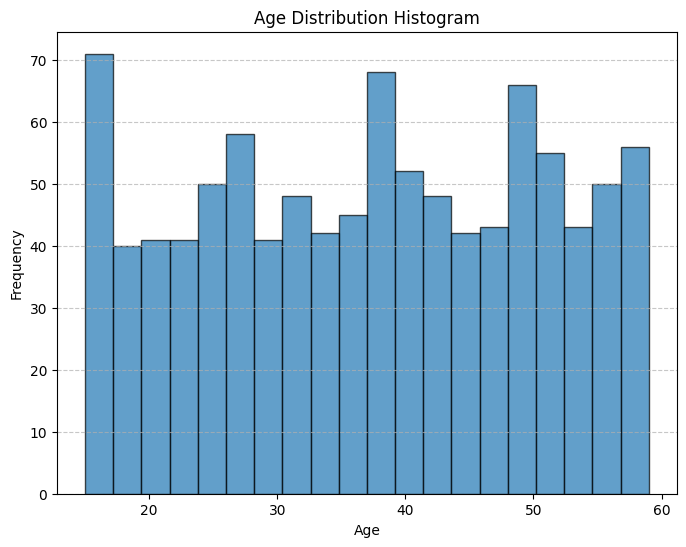

In [25]:
plt.figure(figsize=(8, 6))
plt.hist(incidents_data["Age"], bins = 20, edgecolor="black", alpha=0.7)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution Histogram")
plt.grid(axis="y", linestyle="--", alpha=0.7)

In [26]:
expenses_data = pd.read_csv('expenses.csv')
expenses_data.head()

,Transaction_ID,Transaction_Type,Category,Amount,Date,Season,Weather,Customer_ID,Incident_ID
0,0,Revenue,Ticket Sale,3500,2025-02-25,Winter,Foggy,1415.0,NaN
1,1,Revenue,Ticket Sale,640,2025-02-25,Winter,Windy,5095.0,NaN
2,2,Expense,Ambulance Call,-1490,2025-02-25,Winter,Foggy,NaN,96.0
3,3,Expense,Equipment Maintenance,-730,2025-02-25,Winter,Sunny,NaN,NaN
4,4,Expense,Staff Salary,-4238,2025-02-25,Summer,Sunny,NaN,NaN


In [27]:
expenses_weather = (
    expenses_data
    .groupby("Weather")
    .agg(
        count=("Weather", "size"),
        total_amount=("Amount", "sum")
        ) 
    .reset_index()
)
expenses_weather

,Weather,count,total_amount
0,Foggy,263,-399355
1,Rainy,348,-518924
2,Snowy,277,-334688
3,Sunny,551,-852655
4,Windy,561,-668231


In [28]:
summer_expenses = (
    expenses_data
    .loc[expenses_data["Season"] == "Summer"]  
    .groupby("Category")
    .agg(
        count=("Category", "size"),
        total_amount=("Amount", "sum") 
        ) 
    .reset_index()
)
summer_expenses

,Category,count,total_amount
0,Ambulance Call,195,-333947
1,Equipment Maintenance,209,-123703
2,Rental,200,15810
3,Staff Salary,198,-1287403
4,Ticket Sale,190,134020


In [93]:
winter_expenses = (
    expenses_data
    .loc[expenses_data["Season"] == "Winter"]  
    .groupby("Category")
    .agg(
        count=("Category", "size"),
        total_amount=("Amount", "sum") 
        ) 
    .reset_index()
)
winter_expenses

,Category,count,total_amount
0,Ambulance Call,197,-341643
1,Equipment Maintenance,193,-116439
2,Rental,211,34400
3,Staff Salary,188,-1215718
4,Ticket Sale,219,460770


In [29]:
summer_weather = (
    expenses_data
    .loc[expenses_data["Season"] == "Summer"]  
    .groupby("Weather")
    .agg(
        count=("Weather", "size"),
        total_amount=("Amount", "sum") 
        ) 
    .reset_index()
)
summer_weather

,Weather,count,total_amount
0,Rainy,348,-518924
1,Sunny,327,-544994
2,Windy,317,-531305


In [30]:
summer_revenue = (
    expenses_data
    .loc[expenses_data["Season"] == "Summer"]  
    .groupby("Transaction_Type")
    .agg(
        count=("Transaction_Type", "size"),
        total_amount=("Amount", "sum") 
        ) 
    .reset_index()
)
summer_revenue

,Transaction_Type,count,total_amount
0,Expense,602,-1745053
1,Revenue,390,149830


In [31]:
winter_weather = (
    expenses_data
    .loc[expenses_data["Season"] == "Winter"]  
    .groupby("Weather")
    .agg(
        count=("Weather", "size"),
        total_amount=("Amount", "sum") 
        ) 
    .reset_index()
)
winter_weather

,Weather,count,total_amount
0,Foggy,263,-399355
1,Snowy,277,-334688
2,Sunny,224,-307661
3,Windy,244,-136926


# Merging Datasets from this point
### Bear in mind that, the original dataset is 3000 lines, this merged dataset is only around 500 lines => All insights made from this data only represents 1/6 the truth.

In [32]:
common_customer_ID = pd.merge(expenses_data, incidents_data, on=["Customer_ID"])
common_customer_ID

,Transaction_ID,Transaction_Type,Category,Amount,Date,Season_x,Weather_x,Customer_ID,Incident_ID_x,Incident_ID_y,...,Slope_Name,Slope_Difficulty,Skill_Level,Protective_Gear,Injuries,Injury_Severity,Response_Time,Hospital_Transport,Hospital_Stay_Length,Severity_Category
0,16,Revenue,Ticket Sale,7700,2025-02-25,Winter,Foggy,8439.0,NaN,614,...,Thunder Run,Advanced,Intermediate,None,Concussion,6,12,No,0,Moderate
1,16,Revenue,Ticket Sale,7700,2025-02-25,Winter,Foggy,8439.0,NaN,908,...,Thunder Run,Advanced,Advanced,None,Concussion,5,11,No,0,Moderate
2,28,Revenue,Rental,70,2025-02-25,Winter,Sunny,9308.0,NaN,51,...,Shadow Valley,Expert,Beginner,None,Concussion,7,12,No,0,Critical
3,39,Revenue,Rental,315,2025-02-25,Winter,Windy,1110.0,NaN,309,...,Summit Peak,Advanced,Beginner,Helmet,Concussion,8,13,Yes,1,Critical
4,45,Revenue,Rental,240,2025-02-25,Winter,Snowy,1352.0,NaN,648,...,Devil’s Drop,Expert,Beginner,Helmet,Fracture,7,23,No,0,Critical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1962,Revenue,Rental,240,2025-02-25,Winter,Sunny,2989.0,NaN,106,...,Blue Ridge,Intermediate,Intermediate,None,Concussion,7,19,No,0,Critical
98,1968,Revenue,Ticket Sale,480,2025-02-25,Winter,Foggy,2415.0,NaN,374,...,Thunder Run,Advanced,Intermediate,Pads,Sprain,2,13,No,0,Light
99,1985,Revenue,Ticket Sale,320,2025-02-25,Summer,Rainy,2746.0,NaN,58,...,Bunny Hill,Easy,Advanced,None,Fracture,8,14,Yes,4,Critical
100,1985,Revenue,Ticket Sale,320,2025-02-25,Summer,Rainy,2746.0,NaN,547,...,Shadow Valley,Expert,Intermediate,Pads,Fracture,3,12,No,0,Light


In [33]:
common_incidents_ID = pd.merge(expenses_data, incidents_data, on=["Incident_ID"])
common_incidents_ID

,Transaction_ID,Transaction_Type,Category,Amount,Date,Season_x,Weather_x,Customer_ID_x,Incident_ID,Customer_ID_y,...,Slope_Name,Slope_Difficulty,Skill_Level,Protective_Gear,Injuries,Injury_Severity,Response_Time,Hospital_Transport,Hospital_Stay_Length,Severity_Category
0,2,Expense,Ambulance Call,-1490,2025-02-25,Winter,Foggy,NaN,96.0,5352,...,Rocky Pass,Intermediate,Beginner,None,Fracture,8,11,Yes,1,Critical
1,11,Expense,Ambulance Call,-1282,2025-02-25,Summer,Sunny,NaN,775.0,4276,...,Devil’s Drop,Expert,Beginner,None,Concussion,10,26,Yes,3,Critical
2,23,Expense,Ambulance Call,-1016,2025-02-25,Winter,Snowy,NaN,780.0,8757,...,Summit Peak,Advanced,Advanced,Pads,Fracture,8,10,Yes,3,Critical
3,26,Expense,Ambulance Call,-1375,2025-02-25,Summer,Windy,NaN,501.0,9608,...,Rocky Pass,Intermediate,Intermediate,Helmet,Head Injury,8,9,Yes,1,Critical
4,29,Expense,Ambulance Call,-1519,2025-02-25,Winter,Windy,NaN,372.0,6241,...,Bunny Hill,Easy,Intermediate,Helmet,Concussion,8,14,Yes,1,Critical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
387,1970,Expense,Ambulance Call,-1717,2025-02-25,Winter,Windy,NaN,40.0,5291,...,Devil’s Drop,Expert,Beginner,Pads,Fracture,10,25,Yes,3,Critical
388,1975,Expense,Ambulance Call,-1067,2025-02-25,Summer,Rainy,NaN,372.0,6241,...,Bunny Hill,Easy,Intermediate,Helmet,Concussion,8,14,Yes,1,Critical
389,1978,Expense,Ambulance Call,-1216,2025-02-25,Summer,Sunny,NaN,584.0,7782,...,Thunder Run,Advanced,Intermediate,None,Head Injury,8,13,Yes,1,Critical
390,1987,Expense,Ambulance Call,-1449,2025-02-25,Winter,Foggy,NaN,703.0,3932,...,Devil’s Drop,Expert,Beginner,Pads,Concussion,10,15,Yes,1,Critical


In [34]:
common_incidents_ID[common_incidents_ID["Customer_ID_x"].isna() & common_incidents_ID["Customer_ID_y"].isna()]

,Transaction_ID,Transaction_Type,Category,Amount,Date,Season_x,Weather_x,Customer_ID_x,Incident_ID,Customer_ID_y,...,Slope_Name,Slope_Difficulty,Skill_Level,Protective_Gear,Injuries,Injury_Severity,Response_Time,Hospital_Transport,Hospital_Stay_Length,Severity_Category


In [35]:
common_customer_ID[common_customer_ID["Incident_ID_x"].isna() & common_customer_ID["Incident_ID_y"].isna()]

,Transaction_ID,Transaction_Type,Category,Amount,Date,Season_x,Weather_x,Customer_ID,Incident_ID_x,Incident_ID_y,...,Slope_Name,Slope_Difficulty,Skill_Level,Protective_Gear,Injuries,Injury_Severity,Response_Time,Hospital_Transport,Hospital_Stay_Length,Severity_Category


In [36]:
merged_data = pd.concat([common_incidents_ID, common_customer_ID])
merged_data

,Transaction_ID,Transaction_Type,Category,Amount,Date,Season_x,Weather_x,Customer_ID_x,Incident_ID,Customer_ID_y,...,Protective_Gear,Injuries,Injury_Severity,Response_Time,Hospital_Transport,Hospital_Stay_Length,Severity_Category,Customer_ID,Incident_ID_x,Incident_ID_y
0,2,Expense,Ambulance Call,-1490,2025-02-25,Winter,Foggy,NaN,96.0,5352.0,...,None,Fracture,8,11,Yes,1,Critical,NaN,NaN,NaN
1,11,Expense,Ambulance Call,-1282,2025-02-25,Summer,Sunny,NaN,775.0,4276.0,...,None,Concussion,10,26,Yes,3,Critical,NaN,NaN,NaN
2,23,Expense,Ambulance Call,-1016,2025-02-25,Winter,Snowy,NaN,780.0,8757.0,...,Pads,Fracture,8,10,Yes,3,Critical,NaN,NaN,NaN
3,26,Expense,Ambulance Call,-1375,2025-02-25,Summer,Windy,NaN,501.0,9608.0,...,Helmet,Head Injury,8,9,Yes,1,Critical,NaN,NaN,NaN
4,29,Expense,Ambulance Call,-1519,2025-02-25,Winter,Windy,NaN,372.0,6241.0,...,Helmet,Concussion,8,14,Yes,1,Critical,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97,1962,Revenue,Rental,240,2025-02-25,Winter,Sunny,NaN,NaN,NaN,...,None,Concussion,7,19,No,0,Critical,2989.0,NaN,106.0
98,1968,Revenue,Ticket Sale,480,2025-02-25,Winter,Foggy,NaN,NaN,NaN,...,Pads,Sprain,2,13,No,0,Light,2415.0,NaN,374.0
99,1985,Revenue,Ticket Sale,320,2025-02-25,Summer,Rainy,NaN,NaN,NaN,...,None,Fracture,8,14,Yes,4,Critical,2746.0,NaN,58.0
100,1985,Revenue,Ticket Sale,320,2025-02-25,Summer,Rainy,NaN,NaN,NaN,...,Pads,Fracture,3,12,No,0,Light,2746.0,NaN,547.0


In [37]:
merged_file_path = "merged_dataset.csv"
merged_data.to_csv(merged_file_path, index=False)

In [38]:
merged_expense_distribution = (
    merged_data
    .groupby("Transaction_Type")
    .agg(
        count=("Transaction_Type", "size"),
        total_amount=("Amount", "sum") 
        ) 
    .reset_index()
)
merged_expense_distribution

,Transaction_Type,count,total_amount
0,Expense,392,-675590
1,Revenue,102,85655


## Ignore this part please

In [39]:
# Group by 'Category' and count the number of 'Amount' values
ambulance_severity_amount = merged_data.loc[merged_data["Category"] == "Ambulance Call"].groupby("Severity_Category")["Amount"].sum().reset_index(name="Money Loss")

ambulance_severity_amount

,Severity_Category,Money Loss
0,Critical,-675590


In [40]:
merged_data.loc[merged_data["Category"] == "Ambulance Call"].groupby("Slope_Name")["Amount"].sum().reset_index(name="Money Loss")

,Slope_Name,Money Loss
0,Blue Ridge,-93922
1,Bunny Hill,-60250
2,Devil’s Drop,-147119
3,Rocky Pass,-108544
4,Shadow Valley,-104741
5,Summit Peak,-103295
6,Thunder Run,-57719


In [41]:
merged_data.loc[merged_data["Category"] == "Ambulance Call"].groupby("Slope_Name")["Category"].count().reset_index(name="Number of incidents")

,Slope_Name,Number of incidents
0,Blue Ridge,55
1,Bunny Hill,36
2,Devil’s Drop,87
3,Rocky Pass,62
4,Shadow Valley,60
5,Summit Peak,58
6,Thunder Run,34


In [42]:
merged_data.loc[merged_data["Category"] == "Ambulance Call"].groupby("Slope_Difficulty")["Amount"].sum().reset_index(name="Money Loss")

,Slope_Difficulty,Money Loss
0,Advanced,-161014
1,Easy,-60250
2,Expert,-251860
3,Intermediate,-202466


In [43]:
merged_data.loc[merged_data["Category"] == "Ambulance Call"].groupby("Slope_Difficulty")["Category"].count().reset_index(name="Number of incidents")

,Slope_Difficulty,Number of incidents
0,Advanced,92
1,Easy,36
2,Expert,147
3,Intermediate,117


In [44]:
merged_data.loc[merged_data["Category"] == "Ambulance Call"].groupby("Protective_Gear")["Amount"].sum().reset_index(name="Money Loss")

,Protective_Gear,Money Loss
0,Helmet,-203825
1,None,-273762
2,Pads,-198003


In [45]:
merged_data.loc[merged_data["Category"] == "Ambulance Call"].groupby("Injuries")["Amount"].sum().reset_index(name="Money Loss")

,Injuries,Money Loss
0,Concussion,-140893
1,Fracture,-318520
2,Head Injury,-101147
3,Sprain,-115030


# Continue Reading

In [46]:
merged_data.loc[merged_data["Category"] == "Ticket Sale"].groupby("Activity")["Amount"].sum().reset_index(name="Money Gain from ticket sale")

,Activity,Money Gain from ticket sale
0,Climbing,8770
1,Hiking,6050
2,Mountain Biking,15830
3,Skiing,11840
4,Snowboarding,34310


In [47]:
merged_data.loc[merged_data["Category"] == "Rental"].groupby("Activity")["Amount"].sum().reset_index(name="Money Gain from rental")

,Activity,Money Gain from rental
0,Climbing,855
1,Hiking,1915
2,Mountain Biking,1985
3,Skiing,1010
4,Snowboarding,3090


In [48]:
merged_data.loc[merged_data["Category"] == "Ticket Sale"].groupby("Slope_Name")["Amount"].sum().reset_index(name="Money Gain from ticket sale")

,Slope_Name,Money Gain from ticket sale
0,Blue Ridge,4930
1,Bunny Hill,6890
2,Devil’s Drop,6980
3,Rocky Pass,720
4,Shadow Valley,8450
5,Summit Peak,23920
6,Thunder Run,24910


In [49]:
merged_data.loc[merged_data["Category"] == "Rental"].groupby("Slope_Name")["Amount"].sum().reset_index(name="Money Gain from rental")

,Slope_Name,Money Gain from rental
0,Blue Ridge,1620
1,Bunny Hill,665
2,Devil’s Drop,1620
3,Rocky Pass,805
4,Shadow Valley,525
5,Summit Peak,2500
6,Thunder Run,1120


In [50]:
merged_data.loc[merged_data["Category"] == "Ticket Sale"].groupby("Slope_Difficulty")["Amount"].sum().reset_index(name="Money Gain from ticket sale")

,Slope_Difficulty,Money Gain from ticket sale
0,Advanced,48830
1,Easy,6890
2,Expert,15430
3,Intermediate,5650


In [51]:
merged_data.loc[merged_data["Category"] == "Rental"].groupby("Slope_Difficulty")["Amount"].sum().reset_index(name="Money Gain from rental")

,Slope_Difficulty,Money Gain from rental
0,Advanced,3620
1,Easy,665
2,Expert,2145
3,Intermediate,2425


In [52]:
merged_data.loc[merged_data["Category"] == "Ticket Sale"].groupby("Skill_Level")["Amount"].sum().reset_index(name="Money Gain from ticket sale")

,Skill_Level,Money Gain from ticket sale
0,Advanced,32180
1,Beginner,11410
2,Intermediate,33210


In [53]:
merged_data.loc[merged_data["Category"] == "Rental"].groupby("Skill_Level")["Amount"].sum().reset_index(name="Money Gain from rental")

,Skill_Level,Money Gain from rental
0,Advanced,3495
1,Beginner,2335
2,Intermediate,3025


In [54]:
merged_data.loc[merged_data["Category"] == "Rental"].groupby("Protective_Gear")["Amount"].sum().reset_index(name="Money Gain from rental")

,Protective_Gear,Money Gain from rental
0,Helmet,2675
1,None,3345
2,Pads,2835
